In [1]:
import sys

sys.path.append("../")
import pandas as pd
from config.settings import MONGO_CONNECTION_STRING

from src.indicators.sma import calculate_sma
from pymongo import MongoClient

In [2]:
client = MongoClient(
    MONGO_CONNECTION_STRING,
    tls=True,
    tlsAllowInvalidCertificates=True,  # For development only
    # tlsCAFile='/Users/tyrelle/Desktop/4ex.ninja/4ex.ninja/config/global-bundle.pem'
)

In [3]:
db = client["forex_data"]
collections = db.list_collection_names()

In [4]:
# Choose a collection (for example AUD_USD_D)
collection_name = "AUD_USD_D"
collection = db[collection_name]

# Fetch all documents and convert to DataFrame
df_AUDUSD_D = pd.DataFrame(list(collection.find()))

# Set the time column as the index
df_AUDUSD_D.set_index("time", inplace=True)

# Extract OHLC values from the mid dictionary
df_AUDUSD_D["open"] = df_AUDUSD_D["mid"].apply(lambda x: float(x["o"]))
df_AUDUSD_D["high"] = df_AUDUSD_D["mid"].apply(lambda x: float(x["h"]))
df_AUDUSD_D["low"] = df_AUDUSD_D["mid"].apply(lambda x: float(x["l"]))
df_AUDUSD_D["close"] = df_AUDUSD_D["mid"].apply(lambda x: float(x["c"]))

# Drop unnecessary columns and reorder
df_AUDUSD_D = df_AUDUSD_D[["volume", "open", "high", "low", "close"]]

# Display information about the data
print(f"\nDataFrame info for {collection_name}:")
print(f"Total number of candles: {len(df_AUDUSD_D)}")
print("\nFirst few rows:")
print(df_AUDUSD_D.head())


DataFrame info for AUD_USD_D:
Total number of candles: 2594

First few rows:
                     volume     open     high      low    close
time                                                           
2015-02-15 22:00:00    8666  0.77728  0.77948  0.77518  0.77724
2015-02-16 22:00:00   11781  0.77736  0.78290  0.77422  0.78180
2015-02-17 22:00:00   12082  0.78196  0.78390  0.77737  0.78112
2015-02-18 22:00:00   12375  0.78096  0.78433  0.77572  0.77927
2015-02-19 22:00:00   12284  0.77927  0.78488  0.77885  0.78414


In [14]:
import numpy as np


def identify_multiple_ma_crossovers(df, ma_pairs):
    """
    Identify MA crossover signals for multiple MA combinations

    Parameters:
    df : pandas DataFrame with price data
    ma_pairs : list of tuples, each containing (fast_period, slow_period)

    Returns:
    DataFrame with signals for each MA combination
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Calculate all required MAs
    for fast, slow in ma_pairs:
        df[f"SMA_{fast}"] = df["close"].rolling(window=fast).mean()
        df[f"SMA_{slow}"] = df["close"].rolling(window=slow).mean()

        # Generate signals for this MA pair
        signal_col = f"signal_{fast}_{slow}"
        df[signal_col] = np.where(
            (df[f"SMA_{fast}"] > df[f"SMA_{slow}"])
            & (df[f"SMA_{fast}"].shift(1) <= df[f"SMA_{slow}"].shift(1)),
            1,  # Buy signal
            np.where(
                (df[f"SMA_{fast}"] < df[f"SMA_{slow}"])
                & (df[f"SMA_{fast}"].shift(1) >= df[f"SMA_{slow}"].shift(1)),
                -1,  # Sell signal
                0,  # No signal
            ),
        )

    return df


# Example usage:
ma_pairs = [(200, 10), (200, 10), (200, 50), (100, 10), (200, 40), (60, 40), (200, 20)]


# Apply to your DataFrame
df_with_signals = identify_multiple_ma_crossovers(df_AUDUSD_D, ma_pairs)

# Print columns with signals
signal_columns = [col for col in df_with_signals.columns if col.startswith("signal_")]
print("\nSignal columns created:")
for col in signal_columns:
    print(f"- {col}")

# Example: Count signals for each MA pair
for col in signal_columns:
    buy_signals = (df_with_signals[col] == 1).sum()
    sell_signals = (df_with_signals[col] == -1).sum()
    print(f"\n{col}:")
    print(f"Buy signals: {buy_signals}")
    print(f"Sell signals: {sell_signals}")


Signal columns created:
- signal_200_10
- signal_200_50
- signal_100_10
- signal_200_40
- signal_60_40
- signal_200_20

signal_200_10:
Buy signals: 16
Sell signals: 16

signal_200_50:
Buy signals: 10
Sell signals: 10

signal_100_10:
Buy signals: 27
Sell signals: 27

signal_200_40:
Buy signals: 11
Sell signals: 11

signal_60_40:
Buy signals: 30
Sell signals: 30

signal_200_20:
Buy signals: 13
Sell signals: 13


In [15]:
def backtest_multiple_signals(df, signal_columns):
    """
    Backtest trades based on multiple MA crossover signals.
    Returns a dictionary of results for each MA combination.
    """
    results = {}

    for signal_col in signal_columns:
        trades = []
        open_trade = None

        # Create a copy of DataFrame for this signal
        df_temp = df.copy()

        for time, row in df_temp.iterrows():
            signal = row[signal_col]
            price = row["close"]

            # If there is a signal (non-zero)
            if signal != 0:
                # If no trade is open, open one
                if open_trade is None:
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }
                # If a trade is already open and the new signal is different (a reversal)
                elif signal != open_trade["signal"]:
                    exit_price = price
                    exit_time = time
                    if open_trade["signal"] == 1:  # Buy trade
                        pip_gain = (exit_price - open_trade["entry_price"]) * 10000
                    else:  # Sell trade
                        pip_gain = (open_trade["entry_price"] - exit_price) * 10000

                    trade = {
                        "entry_time": open_trade["entry_time"],
                        "exit_time": exit_time,
                        "entry_price": open_trade["entry_price"],
                        "exit_price": exit_price,
                        "signal": open_trade["signal"],
                        "pip_gain": pip_gain,
                    }
                    trades.append(trade)
                    # Open a new trade with the current signal
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }

        # If a trade is still open at the end, close it
        if open_trade is not None:
            last_time = df_temp.index[-1]
            last_price = df_temp.iloc[-1]["close"]
            if open_trade["signal"] == 1:
                pip_gain = (last_price - open_trade["entry_price"]) * 10000
            else:
                pip_gain = (open_trade["entry_price"] - last_price) * 10000
            trade = {
                "entry_time": open_trade["entry_time"],
                "exit_time": last_time,
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
            trades.append(trade)

        # Store results for this MA combination
        if trades:
            trades_df = pd.DataFrame(trades)
            total_pips = trades_df["pip_gain"].sum()
            num_trades = len(trades_df)
            avg_pips = trades_df["pip_gain"].mean()
            win_rate = (trades_df["pip_gain"] > 0).mean()

            results[signal_col] = {
                "trades": trades_df,
                "total_pips": total_pips,
                "num_trades": num_trades,
                "avg_pips": avg_pips,
                "win_rate": win_rate,
            }

    return results


# Run backtest for all MA combinations
results = backtest_multiple_signals(df_with_signals, signal_columns)

# Print summary of results for each MA combination
print("\nBacktest Results Summary:")
print("-" * 80)
summary_data = []
for ma_combo, result in results.items():
    summary_data.append(
        {
            "MA_Combo": ma_combo,
            "Total_Trades": result["num_trades"],
            "Total_Pips": round(result["total_pips"], 1),
            "Avg_Pips": round(result["avg_pips"], 1),
            "Win_Rate": f"{result['win_rate']*100:.1f}%",
        }
    )

# Convert to DataFrame for better visualization
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Total_Pips", ascending=False)
print(summary_df)


Backtest Results Summary:
--------------------------------------------------------------------------------
        MA_Combo  Total_Trades  Total_Pips  Avg_Pips Win_Rate
4   signal_60_40            60      4891.7      81.5    66.7%
2  signal_100_10            54      3136.0      58.1    77.8%
3  signal_200_40            22      2814.9     128.0    86.4%
0  signal_200_10            32      2162.2      67.6    81.2%
1  signal_200_50            20      2043.8     102.2    75.0%
5  signal_200_20            26      1904.8      73.3    76.9%


In [10]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Convert to DataFrame and sort
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Total_Pips", ascending=False)

# Display full results
print(summary_df)

# Optional: Reset display options to default after viewing
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.float_format')

        MA_Combo  Total_Trades  Total_Pips  Avg_Pips Win_Rate
4   signal_60_40            60     4891.70     81.50    66.7%
2  signal_100_10            54     3136.00     58.10    77.8%
3  signal_200_40            22     2814.90    128.00    86.4%
0  signal_200_10            32     2162.20     67.60    81.2%
1  signal_200_50            20     2043.80    102.20    75.0%


In [16]:
def calculate_atr(df, period=14):
    """
    Calculate Average True Range (ATR)

    Parameters:
    - df: DataFrame with high, low, close prices
    - period: Period for ATR calculation, default 14

    Returns:
    - Series containing ATR values
    """
    df = df.copy()

    # Calculate True Range
    df["tr1"] = df["high"] - df["low"]
    df["tr2"] = abs(df["high"] - df["close"].shift(1))
    df["tr3"] = abs(df["low"] - df["close"].shift(1))

    df["tr"] = df[["tr1", "tr2", "tr3"]].max(axis=1)

    # Calculate ATR
    atr = df["tr"].rolling(window=period).mean()

    return atr


Realistic Backtest Results:
Total Trades: 22
Total Pips: 361.4
Average Pips per Trade: 16.4
Win Rate: 54.5%
Sharpe Ratio: 5.15

Exit Analysis:
----------------------------------------
Exit Type Distribution:
tp: 12 trades (100.0% win rate)
sl: 10 trades (0.0% win rate)

Risk Metrics:
----------------------------------------
Profit Factor: 2.00
Maximum Drawdown: 66.8 pips


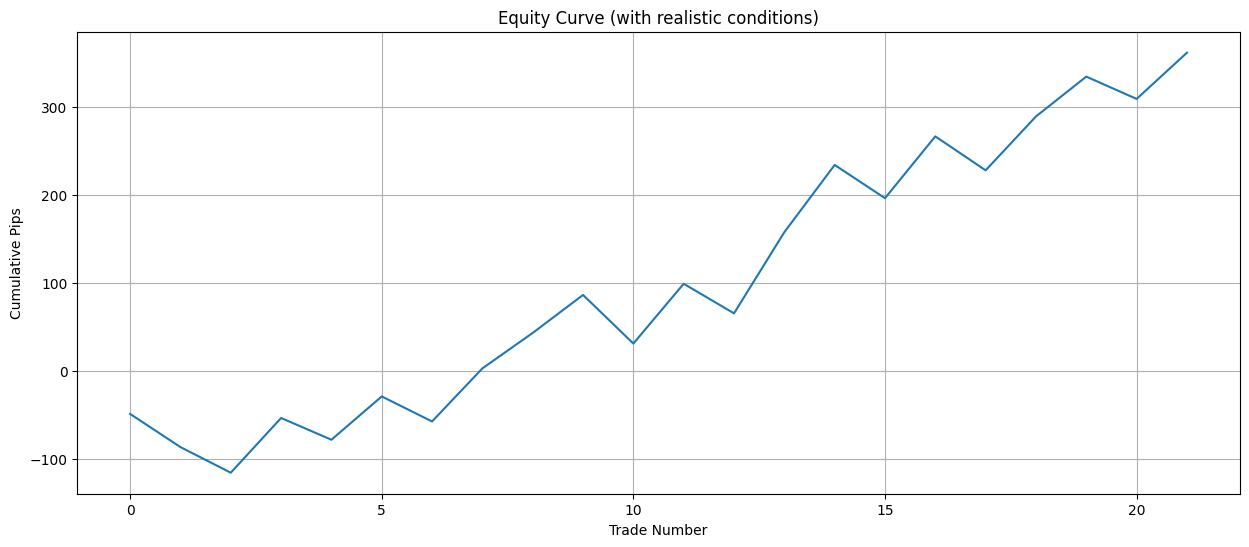

In [24]:
# Import plotting library
import matplotlib.pyplot as plt


def realistic_backtest_with_risk_management(
    df, signal_col, spread_pips=1.0, tp_atr=1.0, sl_atr=0.5, atr_period=14
):
    """
    Add ATR-based stops and targets to realistic backtest
    """
    df = df.copy()
    df["atr"] = calculate_atr(df, atr_period)
    trades = []
    open_trade = None

    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        signal = current_row[signal_col]
        current_atr = current_row["atr"]

        # Handle open trade
        if open_trade is not None:
            # Calculate take-profit and stop-loss levels
            if open_trade["signal"] == 1:
                take_profit = open_trade["entry_price"] + (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] - (current_atr * sl_atr)
                # Check if TP or SL hit
                if next_row["high"] >= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["low"] <= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue
            else:
                take_profit = open_trade["entry_price"] - (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] + (current_atr * sl_atr)
                if next_row["low"] <= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["high"] >= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue

            pip_gain = (exit_price - open_trade["entry_price"]) * 10000
            if open_trade["signal"] == -1:
                pip_gain = -pip_gain

            trades.append(
                {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": next_row.name,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": open_trade["signal"],
                    "pip_gain": pip_gain,
                    "exit_type": exit_type,
                }
            )
            open_trade = None

        # Open new trade
        if signal != 0 and open_trade is None:
            entry_price = next_row["open"]  # Use next bar's open for entry
            if signal == 1:
                entry_price += spread_pips * 0.0001  # Add spread for buying
            else:
                entry_price -= spread_pips * 0.0001  # Subtract spread for selling

            open_trade = {
                "entry_time": next_row.name,
                "entry_price": entry_price,
                "signal": signal,
            }

    # Close any remaining trade
    if open_trade is not None:
        last_price = df.iloc[-1]["close"]
        if open_trade["signal"] == 1:
            last_price -= spread_pips * 0.0001
            pip_gain = (last_price - open_trade["entry_price"]) * 10000
        else:
            last_price += spread_pips * 0.0001
            pip_gain = (open_trade["entry_price"] - last_price) * 10000

        trades.append(
            {
                "entry_time": open_trade["entry_time"],
                "exit_time": df.index[-1],
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
        )

    trades_df = pd.DataFrame(trades)

    # Calculate daily returns for Sharpe Ratio
    if not trades_df.empty:
        daily_returns = trades_df.groupby("exit_time")["pip_gain"].sum()
        avg_return = daily_returns.mean()
        std_return = daily_returns.std()
        sharpe_ratio = np.sqrt(252) * avg_return / std_return if std_return != 0 else 0

        results = {
            "total_pips": trades_df["pip_gain"].sum(),
            "num_trades": len(trades_df),
            "win_rate": (trades_df["pip_gain"] > 0).mean(),
            "avg_pips": trades_df["pip_gain"].mean(),
            "sharpe_ratio": sharpe_ratio,
            "trades": trades_df,
        }
    else:
        results = {
            "total_pips": 0,
            "num_trades": 0,
            "win_rate": 0,
            "avg_pips": 0,
            "sharpe_ratio": 0,
            "trades": trades_df,
        }

    return results


# Run realistic backtest
realistic_results = realistic_backtest_with_risk_management(
    # Make sure to change this to the correct signal column
    df_with_signals,
    "signal_200_40",
)

print("\nRealistic Backtest Results:")
print(f"Total Trades: {realistic_results['num_trades']}")
print(f"Total Pips: {realistic_results['total_pips']:.1f}")
print(f"Average Pips per Trade: {realistic_results['avg_pips']:.1f}")
print(f"Win Rate: {realistic_results['win_rate']*100:.1f}%")
print(f"Sharpe Ratio: {realistic_results['sharpe_ratio']:.2f}")

# After the existing results printing
if len(realistic_results["trades"]) > 0:
    trades_df = realistic_results["trades"]

    # Exit type analysis
    exit_counts = trades_df["exit_type"].value_counts()
    exit_wins = trades_df[trades_df["pip_gain"] > 0]["exit_type"].value_counts()

    print("\nExit Analysis:")
    print("-" * 40)
    print("Exit Type Distribution:")
    for exit_type in exit_counts.index:
        win_count = exit_wins.get(exit_type, 0)
        total_count = exit_counts[exit_type]
        win_rate = (win_count / total_count * 100) if total_count > 0 else 0
        print(f"{exit_type}: {total_count} trades ({win_rate:.1f}% win rate)")

    # Risk metrics
    profit_factor = abs(
        trades_df[trades_df["pip_gain"] > 0]["pip_gain"].sum()
        / trades_df[trades_df["pip_gain"] < 0]["pip_gain"].sum()
    )
    max_drawdown = (
        trades_df["pip_gain"].cumsum()
        - trades_df["pip_gain"].cumsum().expanding().max()
    ).min()

    print("\nRisk Metrics:")
    print("-" * 40)
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Maximum Drawdown: {abs(max_drawdown):.1f} pips")

# Plot equity curve
if len(realistic_results["trades"]) > 0:
    plt.figure(figsize=(15, 6))
    equity_curve = realistic_results["trades"]["pip_gain"].cumsum()
    plt.plot(equity_curve.index, equity_curve)
    plt.title("Equity Curve (with realistic conditions)")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Pips")
    plt.grid(True)
    plt.show()